# Zadanie 14.3

Sprawdź jak zachowuje się model dla różnych regularyzacji i ich stopnia. Zwizualizuj działanie modelu z wykorzystaniem funkcji plot_classification_surface oraz za każdym razem oblicz F1_score na zbiorze treningowym oraz testowym (zobaczysz czy model przypadkiem się nie przeucza).

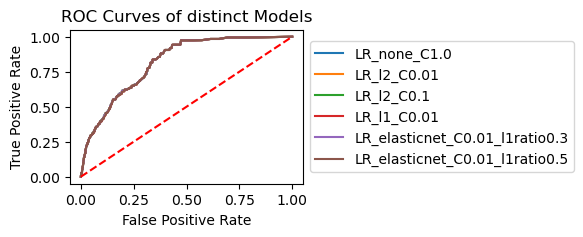


>>> Model: LR_none_C1.0


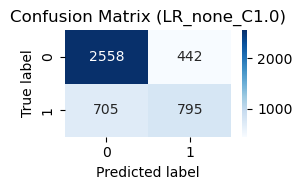

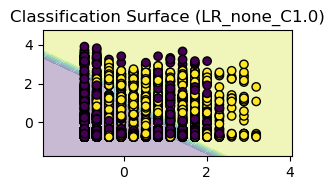


>>> Model: LR_l2_C0.01


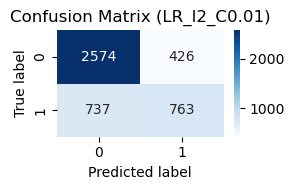

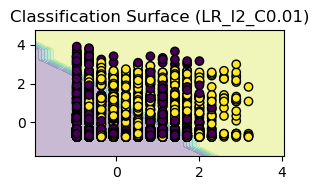


>>> Model: LR_l2_C0.1


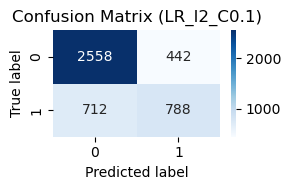

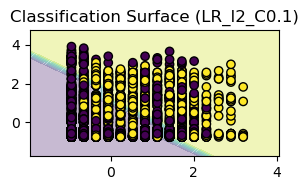


>>> Model: LR_l1_C0.01


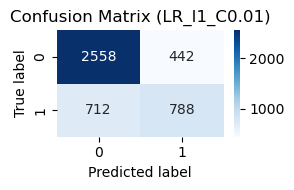

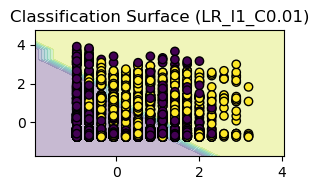


>>> Model: LR_elasticnet_C0.01_l1ratio0.3


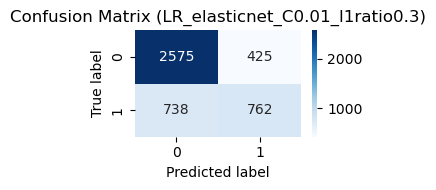

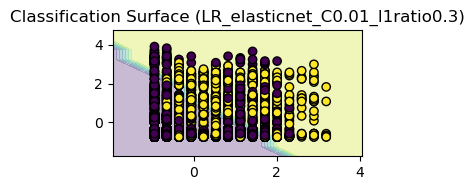


>>> Model: LR_elasticnet_C0.01_l1ratio0.5


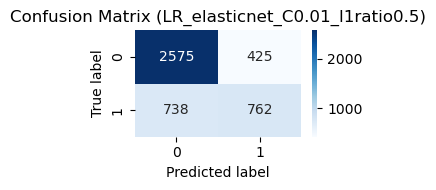

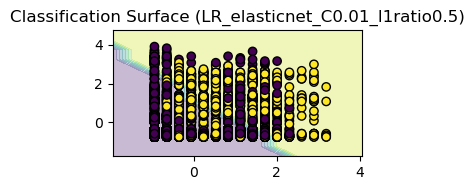


### Zestawienie metryk (bez duplikatów) ###



,Model,Penalty,C,Accuracy,Precision,Recall,F1_score,AUC,l1_ratio
0,LR_none_C1.0,None,1.00,0.745111,0.713313,0.691333,0.698894,0.816493,NaN
1,LR_l2_C0.01,l2,0.01,0.741556,0.709562,0.683333,0.691608,0.816493,NaN
2,LR_l2_C0.1,l2,0.10,0.743556,0.711457,0.689000,0.696619,0.816493,NaN
3,LR_l1_C0.01,l1,0.01,0.743556,0.711457,0.689000,0.696619,0.816045,NaN
4,LR_elasticnet_C0.01_l1ratio0.3,elasticnet,0.01,0.741556,0.709598,0.683167,0.691476,0.816494,0.3
5,LR_elasticnet_C0.01_l1ratio0.5,elasticnet,0.01,0.741556,0.709598,0.683167,0.691476,0.816048,0.5


In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix, 
    roc_curve, 
    roc_auc_score
)
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# --------------------
# 1. Wczytanie danych
# --------------------
diabetes = pd.read_csv('diabetes.csv')

features = [
    'Pregnancies','PlasmaGlucose','DiastolicBloodPressure',
    'TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age'
]
target = 'Diabetic'
X, y = diabetes[features], diabetes[target]

# Używamy tylko 2 cech
X_train, X_test, y_train, y_test = train_test_split(
    X[['Pregnancies', 'Age']], 
    y, 
    test_size=0.30, 
    random_state=0, 
    stratify=y
)

# -------------------
# 2. Standaryzacja
# -------------------
scaler_2var = StandardScaler()
X_train_standardized = scaler_2var.fit_transform(X_train)
X_test_standardized = scaler_2var.transform(X_test)

# -------------------
# 3. Struktury danych
# -------------------
metrics_dataframe = pd.DataFrame(
    columns=['Model', 'Penalty', 'C', 'l1_ratio', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC']
)

stored_models = []
existing_metrics_set = set()  # Zbiór krotek z metrykami, by wykluczać duplikaty

# -----------------------------------------
# Funkcja do obliczania metryk
# -----------------------------------------
def get_metrics(model, X_checked, y_checked):
    y_pred = model.predict(X_checked)
    y_proba = model.predict_proba(X_checked)[:, 1]
    
    report = classification_report(y_checked, y_pred, output_dict=True)
    accuracy = report['accuracy']
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1_metric = report['macro avg']['f1-score']
    auc_metric = roc_auc_score(y_checked, y_proba)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1_metric,
        'auc': auc_metric,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

# --------------------------
# Funkcje do rysowania metryk
# --------------------------
def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix ({model_name})")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


def plot_classification_surface(model, model_name, X_data, y_data):
    x_min, x_max = X_data[:, 0].min() - 1, X_data[:, 0].max() + 1
    y_min, y_max = X_data[:, 1].min() - 1, X_data[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.5),
        np.arange(y_min, y_max, 0.5)
    )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(3, 2))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X_data[:, 0], X_data[:, 1], c=y_data, edgecolors='k')
    plt.title(f"Classification Surface ({model_name})")
    plt.tight_layout()
    plt.show()


def plot_roc_curves(stored_models, X_test, y_test):
    plt.figure(figsize=(3, 2))
    for (model, name, _, y_proba) in stored_models:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=name)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title("ROC Curves of distinct Models")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# ----------------------------------
# 4. Funkcja "train_and_store"
# ----------------------------------
def train_and_store(
    penalty,
    C,
    l1_ratio,
    solver,
    X_train_std,
    y_train,
    X_test_std,
    y_test,
    base_params
):
    global metrics_dataframe, stored_models, existing_metrics_set
    
    model = LogisticRegression(
        penalty=penalty,
        C=C,
        solver=solver,
        l1_ratio=l1_ratio,
        max_iter=15000,
        random_state=0
    )
    model.fit(X_train_std, y_train)
    
    # 1) Sprawdzenie, czy parametry różnią się od bazowych
    if penalty is None: 
        penalty_for_compare = None
    else:
        penalty_for_compare = penalty
    
    if (
        penalty_for_compare == base_params['penalty'] and
        C == base_params['C'] and
        l1_ratio == base_params['l1_ratio']
    ):
        # Taki sam zestaw parametrów jak model bazowy -> pomijamy
        return
    
    # 2) Obliczamy metryki
    metrics = get_metrics(model, X_test_std, y_test)
    
    # 3) Przygotowujemy krotkę z wartościami metryk
    #    (zaokrąglamy, by uniknąć minimalnych różnic float)
    metrics_tuple = (
        round(metrics['accuracy'], 4),
        round(metrics['precision'], 4),
        round(metrics['recall'], 4),
        round(metrics['f1'], 4),
        round(metrics['auc'], 4)
    )
    
    # Jeżeli taki zestaw metryk już istnieje w existing_metrics_set -> pomijamy
    if metrics_tuple in existing_metrics_set:
        return
    
    # W przeciwnym razie dopisujemy do DF i do stored_models
    existing_metrics_set.add(metrics_tuple)
    
    model_name = f"LR_{penalty_for_compare}_C{C}"
    if l1_ratio is not None:
        model_name += f"_l1ratio{l1_ratio}"
    
    new_row = {
        'Model': model_name,
        'Penalty': penalty_for_compare,
        'C': C,
        'l1_ratio': l1_ratio,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1_score': metrics['f1'],
        'AUC': metrics['auc'],
    }
    
    metrics_dataframe = pd.concat([
        metrics_dataframe,
        pd.DataFrame([new_row])
    ], ignore_index=True)
    metrics_dataframe.dropna(axis=1, how='all', inplace=True)
    
    stored_models.append(
        (model, model_name, metrics['y_pred'], metrics['y_proba'])
    )

# ----------------------------
# 5. Model bazowy
# ----------------------------
base_model = LogisticRegression(
    penalty=None,
    C=1.0,
    solver='lbfgs',
    max_iter=15000,
    random_state=0
)
base_model.fit(X_train_standardized, y_train)

base_metrics = get_metrics(base_model, X_test_standardized, y_test)
base_model_name = "LR_none_C1.0"

base_params = {
    'penalty': None,
    'C': 1.0,
    'l1_ratio': None
}

# Wpis do metrics_dataframe, jednocześnie do existing_metrics_set
base_metrics_tuple = (
    round(base_metrics['accuracy'], 4),
    round(base_metrics['precision'], 4),
    round(base_metrics['recall'], 4),
    round(base_metrics['f1'], 4),
    round(base_metrics['auc'], 4)
)
existing_metrics_set.add(base_metrics_tuple)

metrics_dataframe = pd.concat([
    metrics_dataframe,
    pd.DataFrame([{
        'Model': base_model_name,
        'Penalty': None,
        'C': 1.0,
        'l1_ratio': None,
        'Accuracy': base_metrics['accuracy'],
        'Precision': base_metrics['precision'],
        'Recall': base_metrics['recall'],
        'F1_score': base_metrics['f1'],
        'AUC': base_metrics['auc'],
    }]),
    metrics_dataframe.dropna(axis=1, how='all', inplace=True)
], ignore_index=True)


stored_models.append(
    (base_model, base_model_name, base_metrics['y_pred'], base_metrics['y_proba'])
)

# --------------------------------------------
# 6. Tworzenie kolejnych modeli w pętli
# --------------------------------------------
penalties = [None, 'l2', 'l1', 'elasticnet']
C_values = [0.01, 0.1, 1, 10, 100]
l1_ratios = [0.3, 0.5, 0.7]

for penalty in penalties:
    for C in C_values:
        
        if penalty == 'l1':
            solver = 'liblinear'
            l1_ratio = None
            train_and_store(
                penalty,
                C,
                l1_ratio,
                solver,
                X_train_standardized,
                y_train,
                X_test_standardized,
                y_test,
                base_params
            )
            
        elif penalty == 'elasticnet':
            solver = 'saga'
            for l1_ratio in l1_ratios:
                train_and_store(
                    penalty,
                    C,
                    l1_ratio,
                    solver,
                    X_train_standardized,
                    y_train,
                    X_test_standardized,
                    y_test,
                    base_params
                )
        else:
            solver = 'lbfgs'
            l1_ratio = None
            train_and_store(
                penalty,
                C,
                l1_ratio,
                solver,
                X_train_standardized,
                y_train,
                X_test_standardized,
                y_test,
                base_params
            )

# ------------------------------------------
# 7. Wyświetlenie wybranych wyników
# ------------------------------------------

# Zbiorczy wykres ROC dla *unikalnych* modeli
plot_roc_curves(stored_models, X_test_standardized, y_test)

# Dla *unikalnych* modeli rysujemy CM i surface:
for (model, model_name, y_pred, y_proba) in stored_models:
    print(f"\n>>> Model: {model_name}")
    plot_confusion_matrix(model_name, y_test, y_pred)
    plot_classification_surface(model, model_name, X_test_standardized, y_test)

print("\n### Zestawienie metryk (bez duplikatów) ###\n")

metrics_dataframe

# Wnioski

Na podstawie testów widać, że żaden z modeli regularyzowanych nie przewyższył modelu bazowego pod kątem miar Accuracy, F1 czy AUC, a wręcz obniżył wyniki metryk.

Wybór mniejszych wartości C (tj. silniejsza regularyzacja) w l2 i l1 minimalnie obniżał Accuracy, ale różnice są niewielkie.

Modele z regularizacją elasticnet także nie wniosły poprawy względem modelu bazowego. 

Model bazowy jest nominalnie lepszy, ale przy zaokrągleniu wartości nawet ta różnica by zanikła.